In [2]:
import pandas as pd
import pyodbc

In [3]:
# Read the data from access database

dbPath = "./go_sales.accdb"
sales_db = pyodbc.connect(r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=" + dbPath)

In [4]:
# Read the tables from access database
order_details = pd.read_sql("SELECT * FROM order_details", sales_db)
product = pd.read_sql("SELECT * FROM product", sales_db)
order_header = pd.read_sql("SELECT * FROM order_header", sales_db)
order_method = pd.read_sql("SELECT * FROM order_method", sales_db)



C:\Users\manny\AppData\Local\Temp\ipykernel_21272\1281456455.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_details = pd.read_sql("SELECT * FROM order_details", sales_db)
C:\Users\manny\AppData\Local\Temp\ipykernel_21272\1281456455.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  product = pd.read_sql("SELECT * FROM product", sales_db)
C:\Users\manny\AppData\Local\Temp\ipykernel_21272\1281456455.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_header = pd.read_sql("SELECT * FROM order_header", sales_d

### Clean data Before Merging and Plotting

#### Order Method

In [5]:
order_method["ORDER_METHOD_EN"].fillna("Other", inplace=True)
order_method


,ORDER_METHOD_CODE,ORDER_METHOD_EN
0,1,Fax
1,2,Telephone
2,3,Mail
3,4,E-mail
4,5,Other
5,7,Sales visit
6,8,Other


#### Product

In [6]:
# Fill the blanks
product['PRODUCT_NAME'].fillna("Unknown")
product["LANGUAGE"] = product["LANGUAGE"].fillna("EN")
# swap the columns
def swapProductName(productNumber, row):
    target = product["PRODUCT_NUMBER"].astype(int) == productNumber
    product.loc[target, ["PRODUCT_NAME", row]] = product.loc[target, [row, "PRODUCT_NAME"]].values

swapProductName(20, "MARGIN")
swapProductName(48, "PRODUCTION_COST")
swapProductName(72, "INTRODUCTION_DATE")
swapProductName(33, "DESCRIPTION")
swapProductName(114, "PRODUCT_IMAGE")

product['PRODUCT_NAME'].isna().sum()


5

#### Order Details

In [7]:
averageQT = order_details["QUANTITY"].mean()
order_details["QUANTITY"] = order_details["QUANTITY"].fillna(averageQT)
order_details["QUANTITY"].isna().sum()
order_details.loc[:24]

,ORDER_DETAIL_CODE,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE
0,1,5585,16,140.000000,78814,2,2
1,1.02,None,16,330.000000,47860,2.06,1.8
2,1.63,8242,16,128.000000,1,2,98758
3,1.7,2384,16,192.000000,1.02,2.05,53677
4,1.79,7323,93,138.000000,84733,4.5,4.5
5,1.83,6952,None,261.110576,113408,5.5,5.5
6,1.85,7350,94,112.000000,84743,4.63,4.63
7,1.86,8291,86,18.000000,97197,5.59,5.59
8,1.88,1879,88,244.000000,50829,6.63,5.78
9,1.9,5285,94,96.000000,77909,4.78,4.78


In [8]:
# Merge the tables
data = pd.merge(order_details, product, on="PRODUCT_NUMBER")
data = pd.merge(data, order_header, on="ORDER_NUMBER")
data = pd.merge(data, order_method, on="ORDER_METHOD_CODE")

In [9]:
# Create a new column
data["QUANTITY"] =  data["QUANTITY"].astype(float).where(data["QUANTITY"].notnull(), 0)
data["UNIT_PRICE"] = data["UNIT_PRICE"].astype(float).where(data["UNIT_PRICE"].notnull(), 0)
data["total_revenue"] = data["QUANTITY"] * data["UNIT_PRICE"]
data["countQuantity"] = data["QUANTITY"].astype(float).sum()

In [10]:

# Clean dates
data["ORDER_DATE"] = pd.to_datetime(data["ORDER_DATE"])
data["YEAR"] = data["ORDER_DATE"].dt.year
data["YEAR"] = data["YEAR"].fillna('Unknown')

# Revenue per Year per Amount of Products

<AxesSubplot: xlabel='YEAR'>

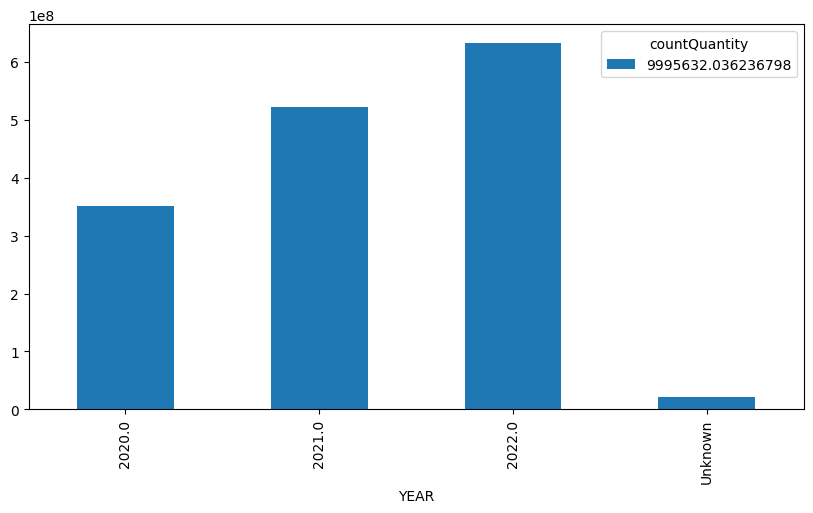

In [11]:
 
data.groupby(["YEAR", "countQuantity"])["total_revenue"].sum().unstack().plot(kind="bar", stacked=True, figsize=(10, 5))

# Revenue per Year per product

<AxesSubplot: xlabel='YEAR'>

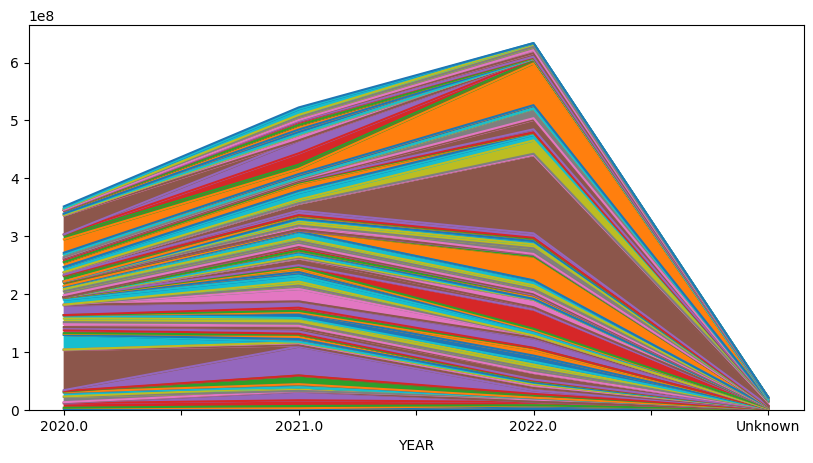

In [12]:
data.groupby(["YEAR", data['PRODUCT_NAME'].astype(str)])["total_revenue"].sum().unstack().plot(kind="area", stacked=True, figsize=(10, 5), legend=False)

# Revenue per Year per Month

<AxesSubplot: xlabel='YEAR'>

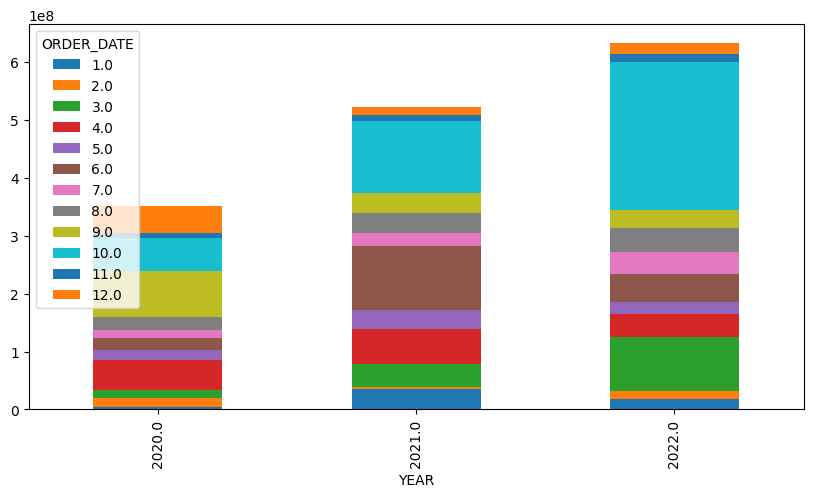

In [14]:
data.groupby(["YEAR", data["ORDER_DATE"].dt.month])["total_revenue"].sum().unstack().plot(kind="bar", stacked=True, figsize=(10, 5))

# Revenue per Year per Payment Method

<AxesSubplot: xlabel='YEAR'>

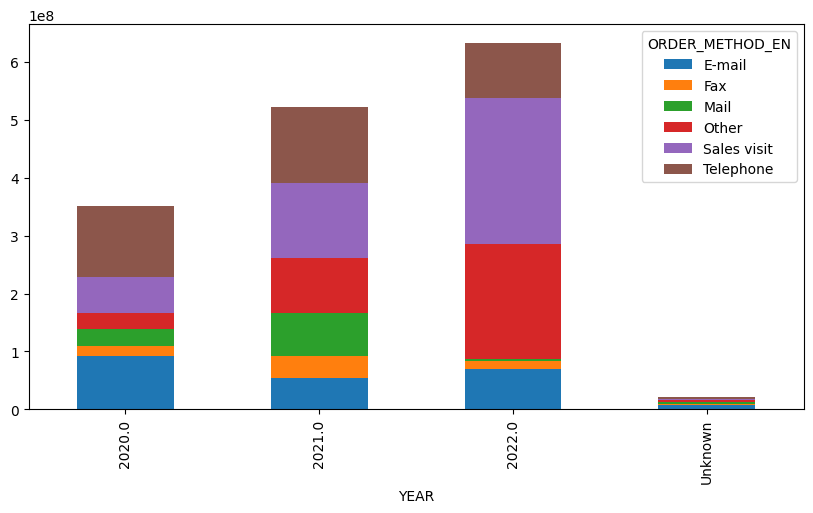

In [15]:
data.groupby(["YEAR", "ORDER_METHOD_EN"])["total_revenue"].sum().unstack().plot(kind="bar", stacked=True, figsize=(10, 5))